# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


class MyBinaryLogisticRegression:
    def __init__(self, method='gd', regularization=None, lambda_1=0.1, lambda_2=0.1, 
                 lr=0.01, max_iter=1000, tol=1e-4, batch_size=32):
        """
        method: 'gd', 'sgd', 'newton'
        regularization: None, 'l1', 'l2', 'l1l2'
        """
        self.method = method
        self.regularization = regularization
        self.l1 = lambda_1
        self.l2 = lambda_2
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
        self.losses_ = []
        self.coefs_ = None
        self.feature_names_in_ = None


    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


    def reg_loss(self, w):
        loss = 0
        if self.regularization in ['l1', 'l1l2']:
            loss += self.l1 * np.sum(np.abs(w[1:]))
        if self.regularization in ['l2', 'l1l2']:
            loss += self.l2 * np.sum(w[1:]**2)
        
        return loss


    def reg_grad(self, w):
        grad = np.zeros_like(w)
        if self.regularization in ['l1', 'l1l2']:
            # производная модуля - sign(w)
            grad[1:] += self.l1 * np.sign(w[1:])
        if self.regularization in ['l2', 'l1l2']:
            # производная квадрата - 2w
            grad[1:] += 2 * self.l2 * w[1:]
        
        return grad


    def reg_hess(self, w):
        n_feat = w.shape[0]
        hess = np.zeros((n_feat, n_feat))
        if self.regularization in ['l2', 'l1l2']:
            # вторая производная квадрата. Диагональная матрица.
            hess[np.diag_indices(n_feat)] = 2 * self.l2
            hess[0, 0] = 0 
        # для L1 вторая производная равна 0 
        return hess


    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        # проверка совместимости
        if self.method == 'newton' and self.regularization in ['l1', 'l1l2']:
            raise ValueError("Метод Ньютона не совместим с L1 регуляризацией из-за недифференцируемости.")

        self.feature_names_in_ = list(X.columns)
        X_np = np.array(X)
        y_np = np.array(y)
        
        X_aug = np.hstack([np.ones((X_np.shape[0], 1)), X_np])
        n_samples, n_features = X_aug.shape
        
        self.coefs_ = np.zeros(n_features) 
        
        for i in range(self.max_iter):

            if self.method == 'sgd':
                indices = np.random.choice(n_samples, self.batch_size, replace=False)
                X_batch, y_batch = X_aug[indices], y_np[indices]
                factor = n_samples / self.batch_size # нормировка градиента
            else: 
                X_batch, y_batch = X_aug, y_np
                factor = 1.0

            z = X_batch @ self.coefs_
            predictions = self.sigmoid(z)
            
            # градиент
            error = predictions - y_batch
            grad = (X_batch.T @ error) / X_batch.shape[0] 
            grad += self.reg_grad(self.coefs_) / n_samples 

            if self.method == 'newton':
                # Гессиан   H = X^T * S * X, где S = diag(p * (1-p))
                W_diag = predictions * (1 - predictions)
                #  X^T @ S @ X
                H = (X_batch.T * W_diag) @ X_batch / X_batch.shape[0]
                H += self.reg_hess(self.coefs_) / n_samples
                
                H += np.eye(n_features) * 1e-5 
                
                # w = w - H^-1 * grad
                update = np.linalg.inv(H) @ grad
                self.coefs_ -= update
            
            else:
                self.coefs_ -= self.lr * grad

            # проверка сходимости (на полных данных)
            if i % 10 == 0:
                
                full_z = X_aug @ self.coefs_
                full_p = self.sigmoid(full_z)

                loss = -np.mean(y_np * np.log(full_p + 1e-15) + (1 - y_np) * np.log(1 - full_p + 1e-15))
                loss += self.reg_loss(self.coefs_) / n_samples
                self.losses_.append(loss)
                
                if len(self.losses_) > 1 and abs(self.losses_[-1] - self.losses_[-2]) < self.tol:
                    break


    def predict(self, X: np.array):
        X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
        z = X_aug @ self.coefs_
        probs = self.sigmoid(z)
        
        return (probs > 0.5).astype(int)


    def score(self, X: np.array, y: np.array):
        y_pred = self.predict(X)
        # F1 score 
        tp = np.sum((y == 1) & (y_pred == 1))
        fp = np.sum((y == 0) & (y_pred == 1))
        fn = np.sum((y == 1) & (y_pred == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        if precision + recall == 0:
            return 0
        
        return 2 * (precision * recall) / (precision + recall)

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [3]:
df = pd.read_csv('penguins_binary_classification.csv')

# нормализация значений
df['flipper_length_cm'] = df['flipper_length_mm'] / 10
df['body_mass_kg'] = df['body_mass_g'] / 1000
df.drop(columns=['flipper_length_mm', 'body_mass_g'], inplace=True)

df['species'] = df['species'].apply(lambda x: 1 if 'Gentoo' in str(x) else 0)

dummies_island = pd.get_dummies(df['island'], prefix='island', drop_first=True, dtype=int)
dummies_year = pd.get_dummies(df['year'], prefix='year', drop_first=True, dtype=int)
df = pd.concat([df, dummies_island, dummies_year], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            274 non-null    int64  
 1   island             274 non-null    object 
 2   bill_length_mm     274 non-null    float64
 3   bill_depth_mm      274 non-null    float64
 4   year               274 non-null    int64  
 5   flipper_length_cm  274 non-null    float64
 6   body_mass_kg       274 non-null    float64
 7   island_Dream       274 non-null    int64  
 8   island_Torgersen   274 non-null    int64  
 9   year_2008          274 non-null    int64  
 10  year_2009          274 non-null    int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 23.7+ KB


In [4]:
df.species.value_counts()

species
0    151
1    123
Name: count, dtype: int64

In [5]:
X_ohe = df.drop(['species', 'island', 'year'], axis=1)
X_te = df.drop(['species', 'island_Dream', 'island_Torgersen', 'year_2008', 'year_2009'], axis=1)
y = df['species']

X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=42)
X_train_te, X_test_te, _, _ = train_test_split(X_te, y, test_size=0.2, random_state=42)


cols_to_encode = ['island', 'year']

for col in cols_to_encode:
    train_with_target = X_train_te.join(y_train)
    means_map = train_with_target.groupby(col)['species'].mean()
    
    X_train_te[col] = X_train_te[col].map(means_map)
    
    X_test_te[col] = X_test_te[col].map(means_map)
    
    global_mean = y_train.mean()
    X_test_te[col] = X_test_te[col].fillna(global_mean)

scaler = StandardScaler()

X_train_ohe = pd.DataFrame(scaler.fit_transform(X_train_ohe), columns=X_train_ohe.columns)
X_test_ohe = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_test_ohe.columns)

X_train_te = pd.DataFrame(scaler.fit_transform(X_train_te), columns=X_train_te.columns)
X_test_te = pd.DataFrame(scaler.transform(X_test_te), columns=X_test_te.columns)

In [6]:
X_train_te['year'].value_counts()

year
 1.165134    79
-0.086140    74
-1.298049    66
Name: count, dtype: int64

In [7]:
X_test_te['year'].value_counts()

year
-0.086140    21
-1.298049    17
 1.165134    17
Name: count, dtype: int64

In [8]:
# конфигурации
configs = [("GD + None", 'gd', None),
           ("SGD + None", 'sgd', None),
           ("Newton + None", 'newton', None),
           ("GD + L2", 'gd', 'l2'),
           ("SGD + L2", 'sgd', 'l2'),
           ("Newton + L2", 'newton', 'l2'),
           ("GD + L1", 'gd', 'l1'),
           ("SGD + L1", 'sgd', 'l1')]

results = []

print(f"{'Method':<20} | {'Encoding':<10} | {'F1-Score':<10}")
print("-" * 50)

for name, method, reg in configs:
    # Оценка для One-Hot
    model_ohe = MyBinaryLogisticRegression(method=method, regularization=reg, lr=0.1, max_iter=500)
    model_ohe.fit(X_train_ohe, y_train)
    score_ohe = model_ohe.score(X_test_ohe, y_test)
    
    # Оценка для Target Encoding
    model_te = MyBinaryLogisticRegression(method=method, regularization=reg, lr=0.1, max_iter=500)
    model_te.fit(X_train_te, y_train)
    score_te = model_te.score(X_test_te, y_test)
    
    results.append({'name': name,
                    'ohe_score': score_ohe,
                    'te_score': score_te,
                    'ohe_losses': model_ohe.losses_,
                    'te_losses': model_te.losses_})
    
    print(f"{name:<20} | {'One-Hot':<10} | {score_ohe:.4f}")
    print(f"{name:<20} | {'TargetEnc':<10} | {score_te:.4f}")

Method               | Encoding   | F1-Score  
--------------------------------------------------
GD + None            | One-Hot    | 1.0000
GD + None            | TargetEnc  | 1.0000
SGD + None           | One-Hot    | 1.0000
SGD + None           | TargetEnc  | 1.0000
Newton + None        | One-Hot    | 1.0000
Newton + None        | TargetEnc  | 1.0000
GD + L2              | One-Hot    | 1.0000
GD + L2              | TargetEnc  | 1.0000
SGD + L2             | One-Hot    | 1.0000
SGD + L2             | TargetEnc  | 1.0000
Newton + L2          | One-Hot    | 1.0000
Newton + L2          | TargetEnc  | 1.0000
GD + L1              | One-Hot    | 1.0000
GD + L1              | TargetEnc  | 1.0000
SGD + L1             | One-Hot    | 1.0000
SGD + L1             | TargetEnc  | 1.0000


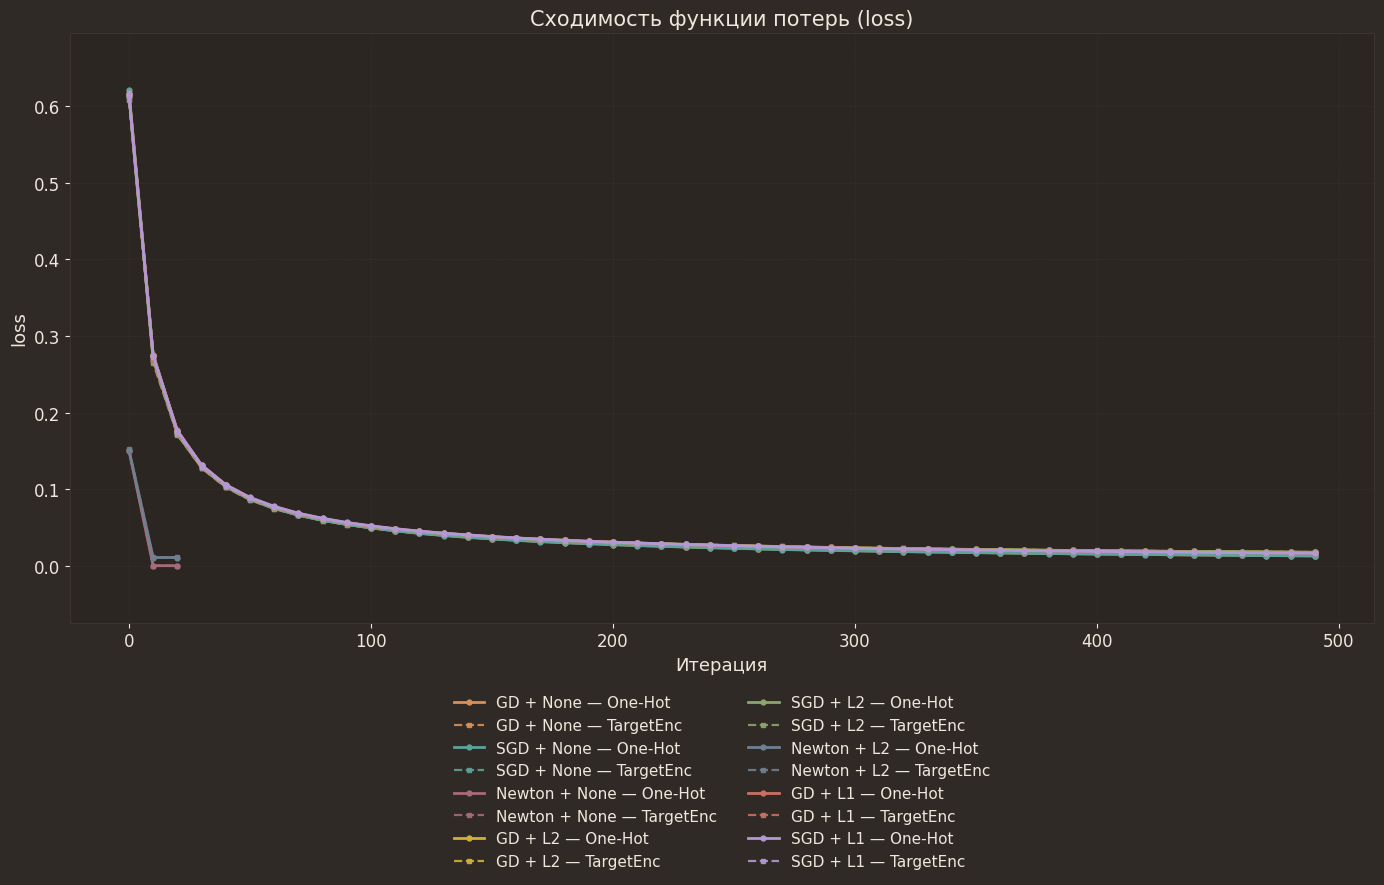

In [9]:
fig_bg = "#2f2a25"        
ax_bg  = "#2b2621"        
text_color = "#efe7dc"    
grid_color = "#3b342f"  

palette = ["#d99058", 
           "#5da399",  
           "#a66b7a", 
           "#d4af37", 
           "#8ca66d",
             "slategrey", 
           "#c97064",
           "#b399d4"]

# ---------- Функция построения ----------
def plot_convergence(results, save_path=None, figsize=(14, 10)):
    """
    Увеличенная высота + вертикальный padding для лучшего различия loss
    """
    plt.rcParams.update({"font.size": 12,
                         "axes.titlesize": 15,
                         "axes.labelsize": 13,
                         "legend.fontsize": 11})

    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(fig_bg)
    ax.set_facecolor(ax_bg)

    all_losses = []

    for idx, r in enumerate(results):
        color = palette[idx % len(palette)]
        name = r["name"]

        ohe_losses = np.array(r["ohe_losses"])
        te_losses  = np.array(r["te_losses"])

        x_ohe = np.arange(len(ohe_losses)) * 10
        x_te  = np.arange(len(te_losses)) * 10

        if len(ohe_losses) > 0:
            ax.plot(
                x_ohe, ohe_losses,
                label=f"{name} — One-Hot",
                color=color,
                linewidth=2.0,
                marker="o",
                markersize=3.5
            )
            all_losses.extend(ohe_losses)

        if len(te_losses) > 0:
            ax.plot(
                x_te, te_losses,
                label=f"{name} — TargetEnc",
                color=color,
                linewidth=1.6,
                linestyle="--",
                marker="s",
                markersize=3,
                alpha=0.9
            )
            all_losses.extend(te_losses)

    all_losses = np.array(all_losses)
    y_min, y_max = all_losses.min(), all_losses.max()
    padding = 0.12 * (y_max - y_min)

    ax.set_ylim(y_min - padding, y_max + padding)

    ax.set_title("Сходимость функции потерь (loss)")
    ax.set_xlabel("Итерация")
    ax.set_ylabel("loss")

    ax.grid(True, linestyle=":", linewidth=0.7, color=grid_color, alpha=0.85)

    ax.tick_params(colors=text_color)
    for spine in ax.spines.values():
        spine.set_color("#3b342f")

    leg = ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=2,
        frameon=False
    )
    for text in leg.get_texts():
        text.set_color(text_color)

    ax.title.set_color(text_color)
    ax.xaxis.label.set_color(text_color)
    ax.yaxis.label.set_color(text_color)

    plt.tight_layout(rect=[0, 0.04, 1, 0.96])

    if save_path:
        plt.savefig(
            save_path,
            dpi=300,
            facecolor=fig.get_facecolor(),
            bbox_inches="tight"
        )

    plt.show()


plot_convergence(results)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression()

lr.fit(X_train_ohe, y_train)

y_pred = lr.predict(X_test_ohe)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        25

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

    Решение:

**Функция потерь:**

Работать с произведением в формуле правдоподобия неудобно (числа становятся очень маленькими), мы берем логарифм со знаком минус (принято минимизировать ошибку, а не максимизировать вероятность). Это называется Cross-Entropy Loss.

$$E(\omega) = - \ln \mathbb P(D|\omega) = - \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij} \ln \left( \frac{\exp(\omega_j^Tx_i)}{\sum_{k=1}^M \exp(\omega_k^Tx_i)} \right)$$

Так получается сумма логарифмов предсказанных вероятностей только для правильных классов (так как $y_{ij}=0$ обнулит слагаемые для неправильных классов).


**Градиент ($\nabla E$):**

Градиент показывает направление наискорейшего роста функции. Чтобы найти минимум ошибки, нужно двигаться в сторону антиградиента, взять производную функции потерь $E$ по весам $\omega_k$ (веса, относящиеся к $k$-му классу). Результат для Softmax:

$$\frac{\partial E}{\partial \omega_k} = \sum_{i=1}^N (P(C_k|x_i) - y_{ik}) x_i$$

$P(C_k|x_i)$ — это то, что модель предсказала. $y_{ik}$ — это истина (1 или 0). Разность $(P - y)$ — это ошибка. Ошибка умножается на сам вектор признаков $x_i$. В матричном виде, если $X$ — матрица признаков ($N \times D$), $Y$ — матрица меток one-hot ($N \times M$), а $P$ — матрица предсказаний ($N \times M$), то градиент:

$$\nabla E = X^T (P - Y)$$


**Гессиан:**

Гессиан — это матрица вторых производных, которая показывает кривизну функции. Она нужна для метода оптимизации Ньютона. Для мультиклассовой логистической регрессии Гессиан — это огромная матрица, состоящая из блоков. Блок, описывающий зависимость весов класса $k$ и класса $m$, выглядит так:

$$H_{km} = \sum_{i=1}^N P(C_k|x_i) (\delta_{km} - P(C_m|x_i)) x_i x_i^T$$

Где $\delta_{km}$ — символ Кронекера (равен 1, если $k=m$, иначе 0). 

Для бинарного случая, Гессиан выглядит так:

$$H = X^T S X$$

Где $S$ — диагональная матрица с весами $p_i(1-p_i)$.

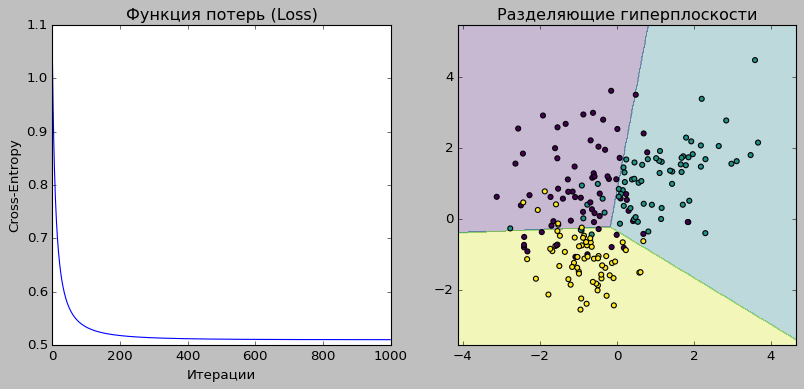

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
plt.style.use('classic')

# 1. Генерация данных
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_classes=3, n_clusters_per_class=1, random_state=42)

# Добавляем единичный столбец (bias)
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

# One-hot кодирование y
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y.reshape(-1, 1)).toarray()

# Softmax (Gradient Descent)
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def get_loss(X, Y, W):
    N = X.shape[0]
    P = softmax(X @ W)

    return -np.sum(Y * np.log(P + 1e-15)) / N

def get_grad(X, Y, W):
    N = X.shape[0]
    P = softmax(X @ W)
    return X.T @ (P - Y) / N

# Обучение
W = np.zeros((X_bias.shape[1], Y_onehot.shape[1])) # Веса (3 признака x 3 класса)
lr = 0.1
losses = []

for i in range(1000):
    grad = get_grad(X_bias, Y_onehot, W)
    W -= lr * grad
    losses.append(get_loss(X_bias, Y_onehot, W))

# 3. Визуализация
plt.figure(figsize=(12, 5))

# График Loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Функция потерь (Loss)")
plt.xlabel("Итерации")
plt.ylabel("Cross-Entropy")

# График разделяющих поверхностей
plt.subplot(1, 2, 2)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_bias = np.hstack([np.ones((grid_points.shape[0], 1)), grid_points])
Z = np.argmax(softmax(grid_bias @ W), axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='viridis')
plt.title("Разделяющие гиперплоскости")
plt.show()